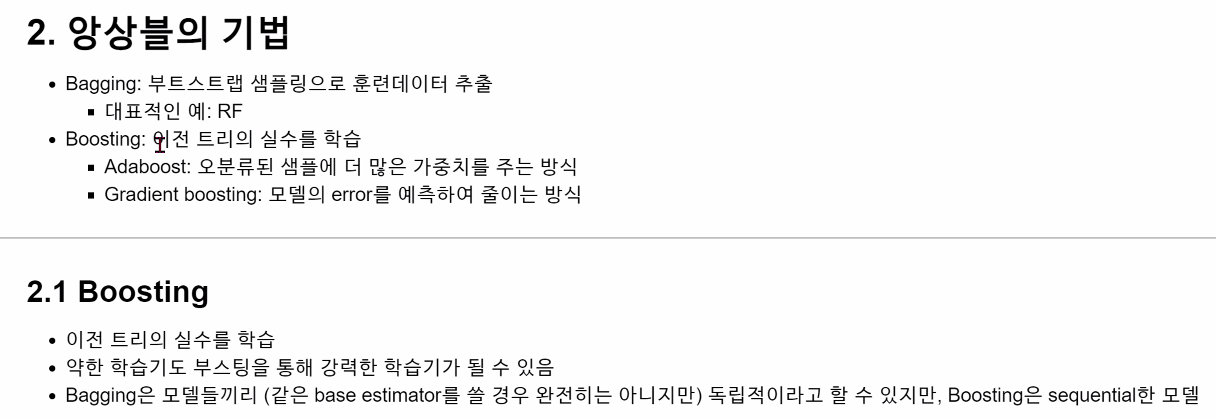

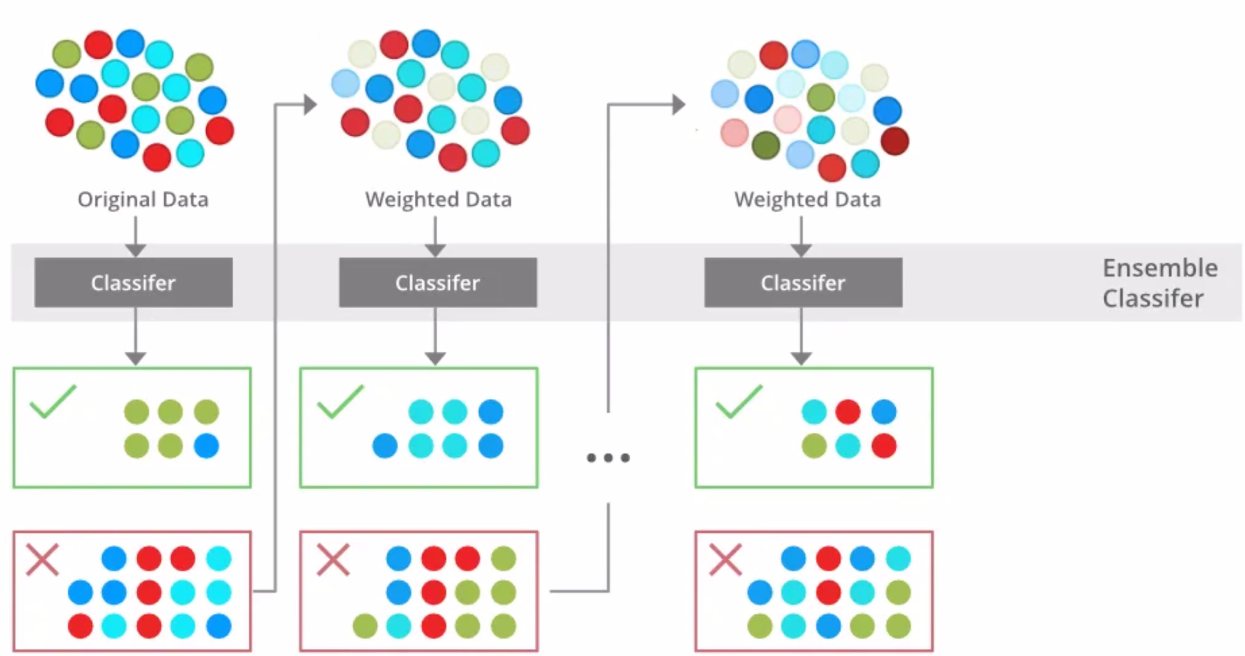

In [12]:
# 부스팅의 가정 -> 약한 학습기 -> 강한 학습기
# 요세는 grediant boosting 을 많이쓴다
# 처음에 너무 잘맞추면 그이후의 학습이 잘안된다

# bagging => 임의 샘플링 => 모델만들고 => 학습 => 투표
# boosting => 앞트리 학습 => 이어서학습 => 반복 => 결과 (sequantial 한 모델이다)
# 속도를 개선한 모델이 xg 부스트

# 종류
    # ada boost
        # 오분류에 대해서 더많은 가중치를 준다.
    # gred boost
        # XG부스트
            #X(extreme) , Gredient 부스트
        # lightGBM
        # Catboost

In [13]:
# 아래의 1표시는 틀린애들은 0 맞으면 1

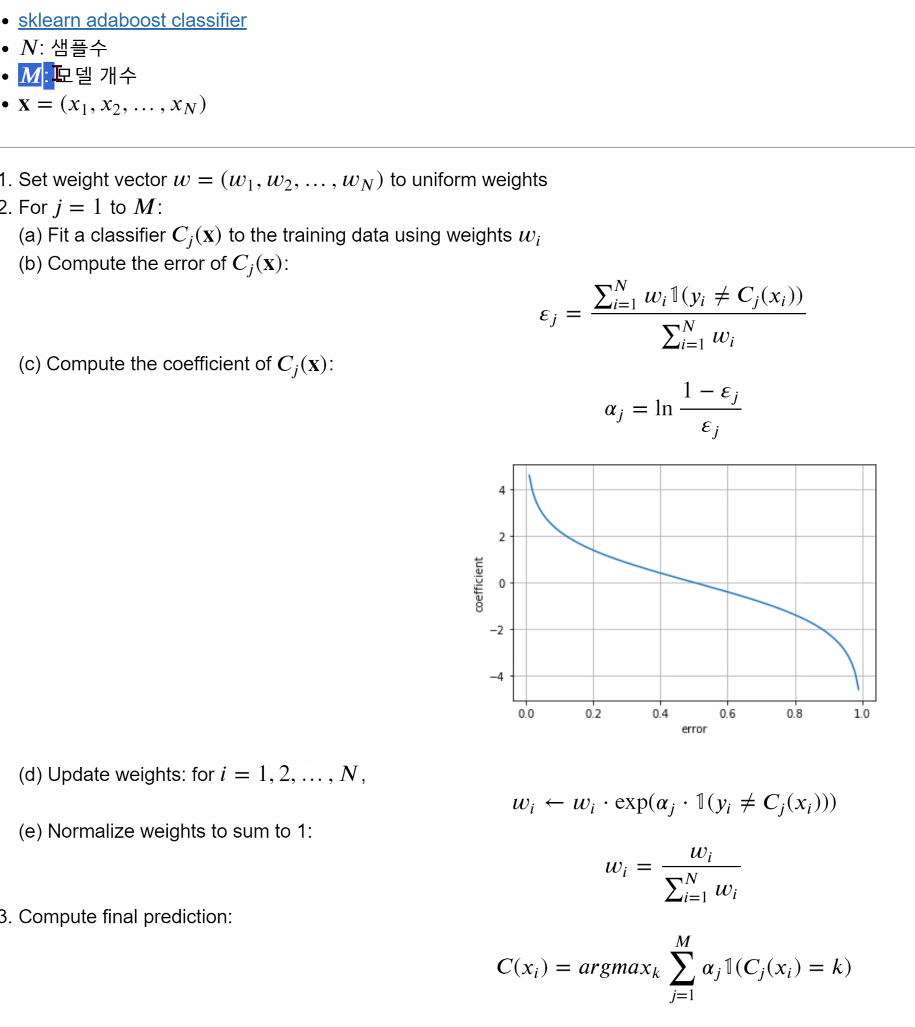

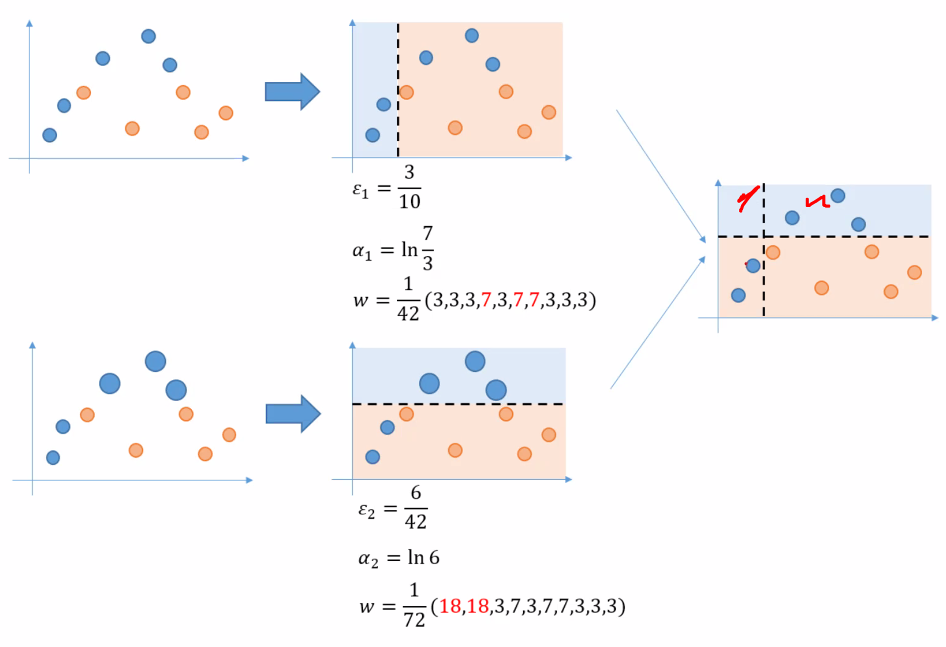

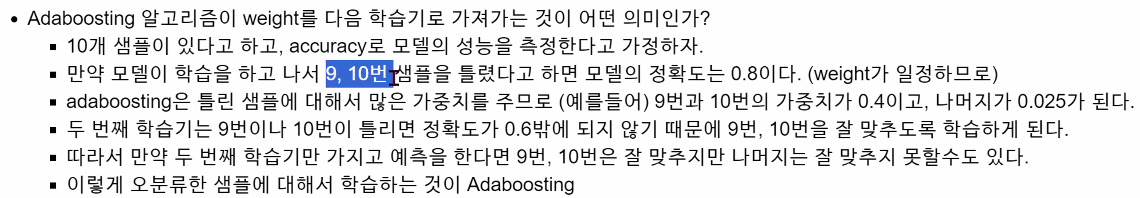

In [14]:
# 오분류 일때 오분류한 샘플에 대하여 가중치가 높게 부여되어 다음학습에 크게 작용된다

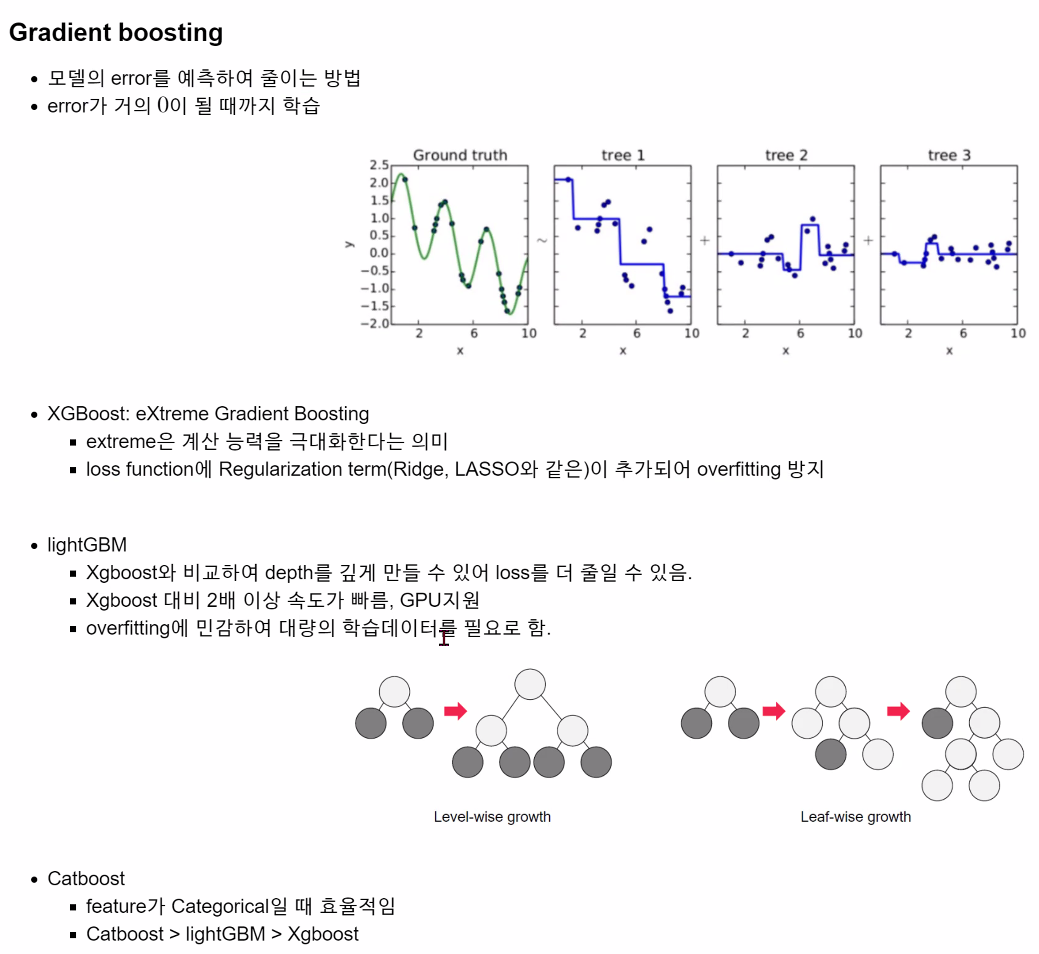

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

import xgboost
from xgboost import XGBClassifier

import time

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [16]:
cencer = load_breast_cancer()

#### cancer 데이터 불러오기

In [17]:
X = cencer["data"]
y = cencer["target"]

x_train,x_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify=y)

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (455, 30)
x_test:  (114, 30)
y_train:  (455,)
y_test:  (114,)


##### ada boost

In [18]:
%%time

ada_acc = []
for i in range(1,30):
    base_model = DecisionTreeClassifier(max_depth=1,random_state=42)

    ada = AdaBoostClassifier(n_estimators=i,base_estimator=base_model)
    ada.fit(x_train,y_train)
    pred_ada = ada.predict(x_test)

    ada_acc.append(metrics.accuracy_score(pred_ada,y_test))

CPU times: total: 188 ms
Wall time: 1.04 s


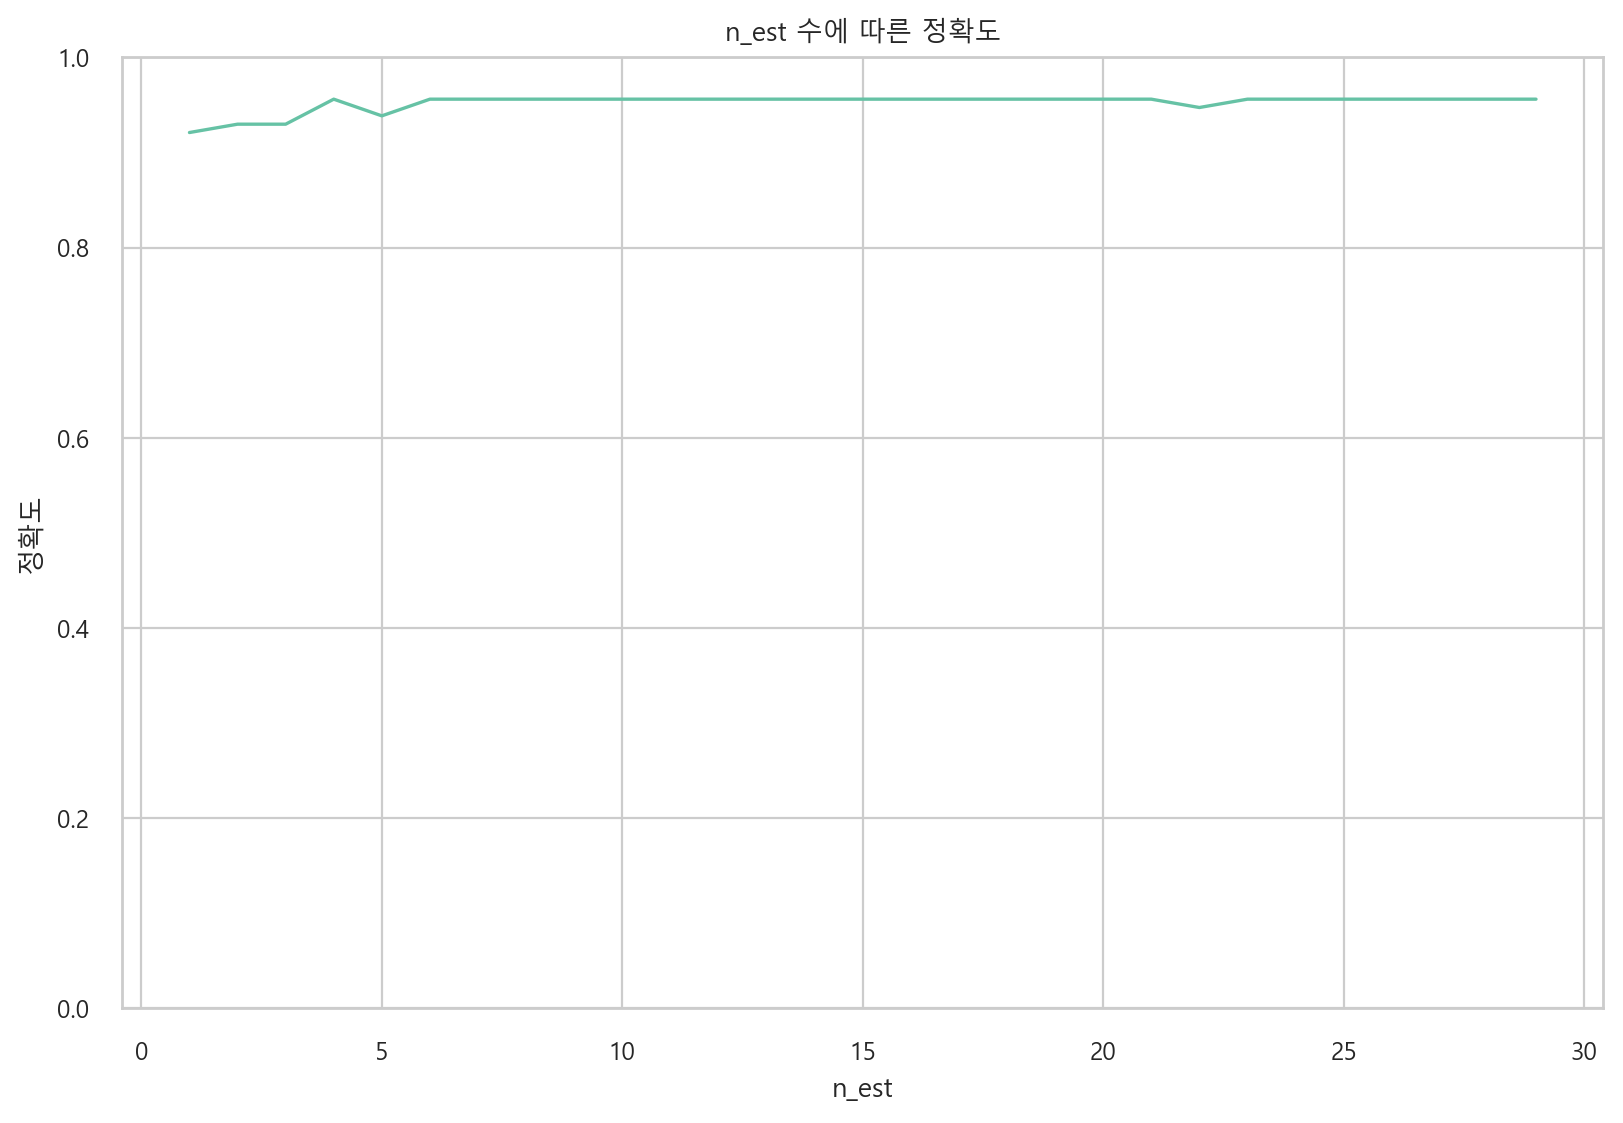

In [23]:
fig, ax = plt.subplots()
sns.lineplot(x = [i for i in range(1,30)],
             y = ada_acc,
             ax=ax)
ax.set(xlabel="n_est",
       ylabel="정확도",
       ylim = [0,1],
       title="n_est 수에 따른 정확도");

##### XGboost

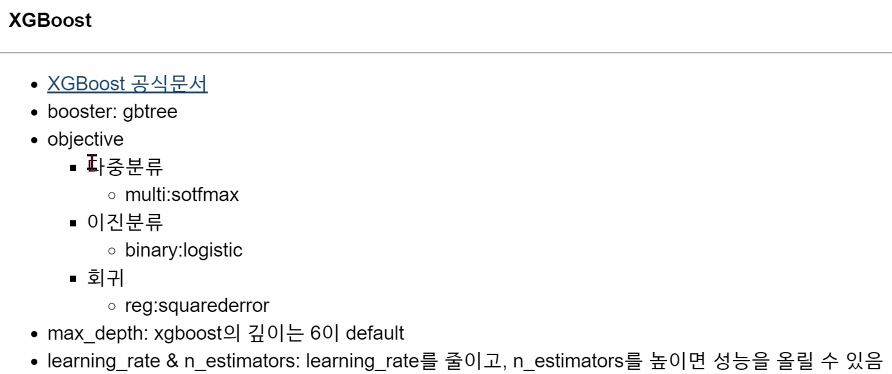

In [24]:
def grid_search(params, model, core):
    model_grid = GridSearchCV(model,
                              params,
                              cv=5,
                              return_train_score=True,
                              n_jobs=core)
    model_grid.fit(x_train,y_train)

    print("최고 매개변수",model_grid.best_params_)
    print("최고 정확도",model_grid.best_score_)

    model_best = model_grid.best_estimator_
    pred_best = model_best.predict(x_test)
    print("테스트에 대한 정확도",metrics.accuracy_score(pred_best, y_test))

    return model_best

params = {"max_depth" : [1,2,3],
    "learning_rate" : np.arange(0.01, 0.1, 0.005),
    "n_estimators" : np.arange(100, 300, 30)}

xgb = XGBClassifier(booster = "gbtree",
                    objective = "binary:logistic")

In [25]:
%%time
best_model = grid_search(params, xgb, -1)

최고 매개변수 {'learning_rate': 0.08999999999999998, 'max_depth': 3, 'n_estimators': 220}
최고 정확도 0.9780219780219781
테스트에 대한 정확도 0.9473684210526315
CPU times: total: 3.58 s
Wall time: 40.1 s


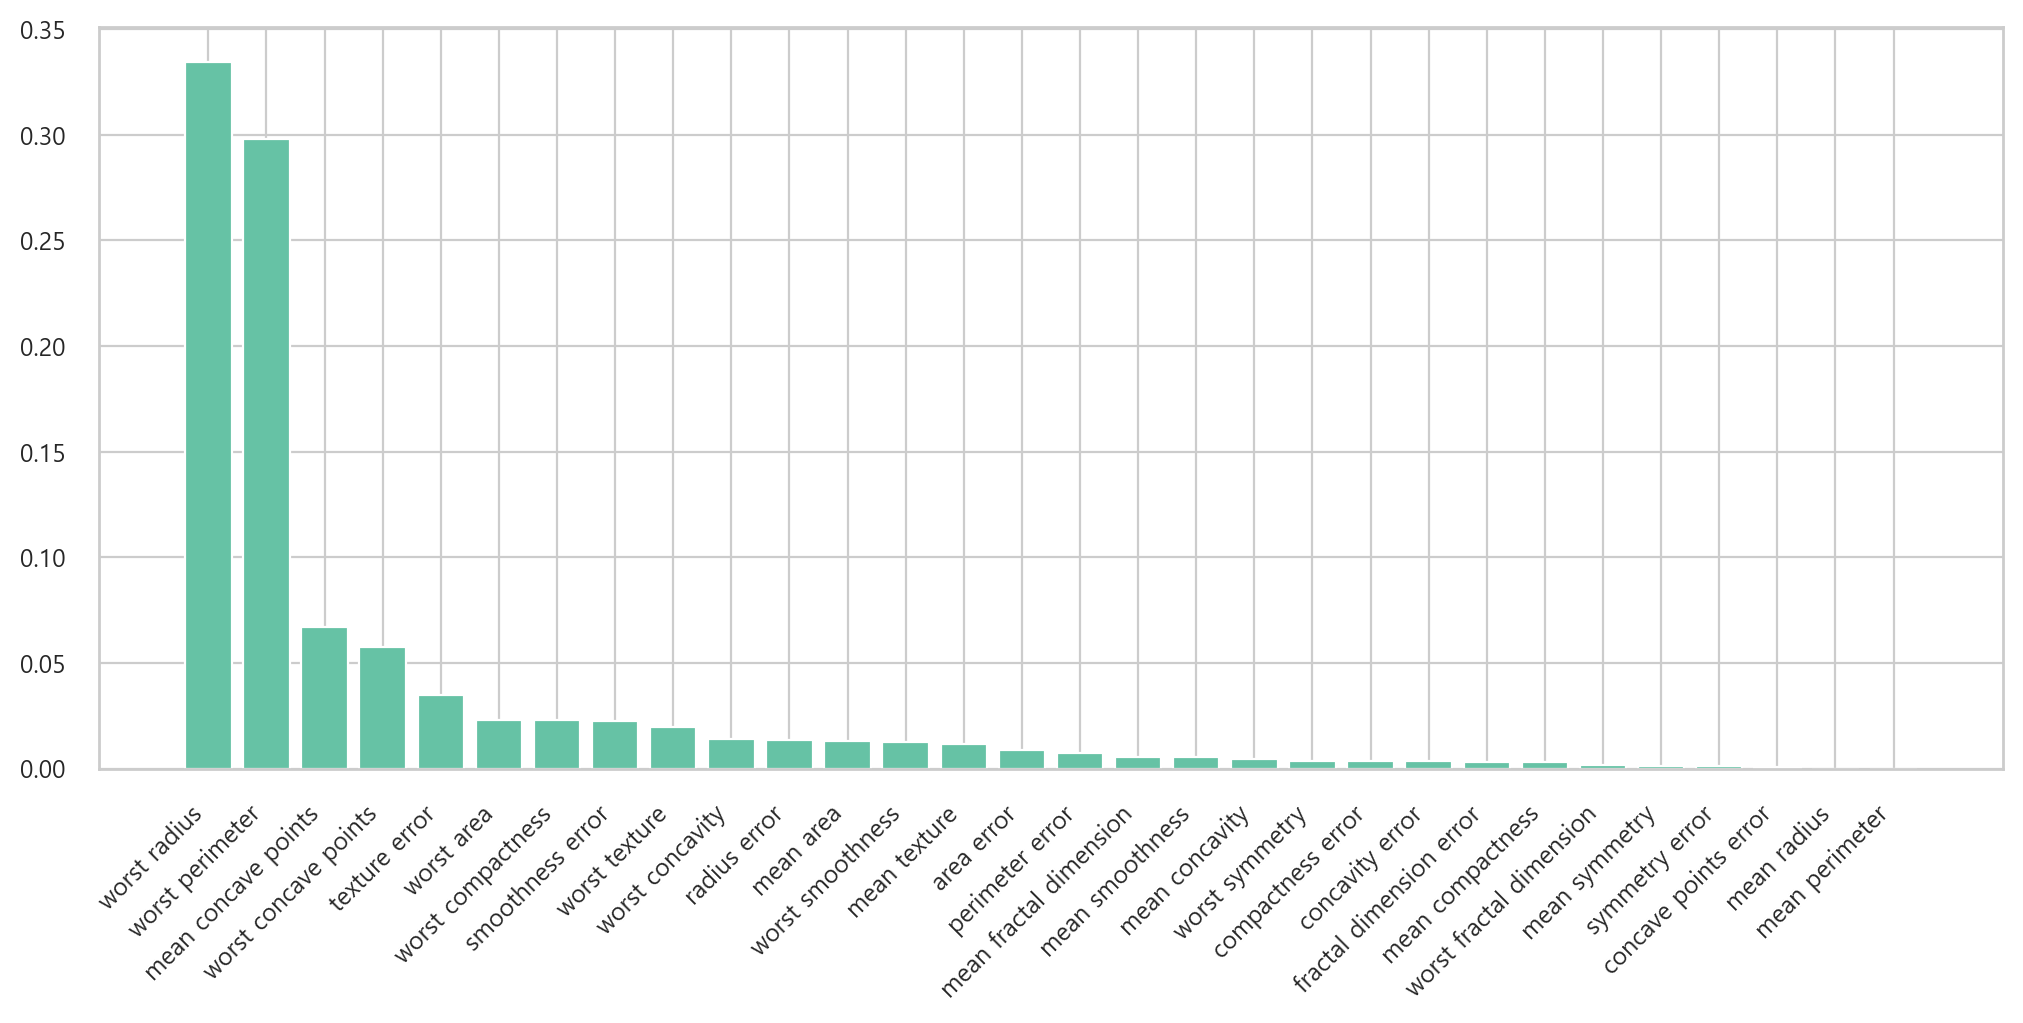

In [ ]:
cencer.feature_names
best_model.feature_importances_

importances = {}
for i in range(len(cencer.feature_names)):
    importances[cencer.feature_names[i]] = best_model.feature_importances_[i]

sorted_keys = sorted(importances, key=importances.get ,reverse=True)
sorted_values = [importances[key] for key in sorted_keys]

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.bar(sorted_keys, sorted_values)
plt.setp(ax.get_xticklabels(), ha = "right", rotation = 45);